In [3]:
import matplotlib.pyplot as plt

import os, PIL

import numpy as np
np.random.seed(1)

import tensorflow as tf
tf.random.set_seed(1)

import warnings
warnings.filterwarnings('ignore')

import pathlib

In [5]:
data_dir = 'train'

data_dir = pathlib.Path(data_dir)

In [7]:
image_count = len(list(data_dir.glob('*/*')))

print('图片总数为:', image_count)

图片总数为: 3400


In [9]:
batch_size = 8
img_height = 224
img_width = 224

In [11]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=12,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=12,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3400 files belonging to 2 classes.
Using 2720 files for training.
Found 3400 files belonging to 2 classes.
Using 680 files for validation.


In [13]:
class_names = train_ds.class_names

print(class_names)

['cat', 'dog']


In [15]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(8, 224, 224, 3)
(8,)


In [17]:
AUTOTUNE = tf.data.AUTOTUNE

def preprocess_image(image, label):
    return (image/255.0, label)

train_ds = train_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

2025-08-24 14:07:59.090764: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


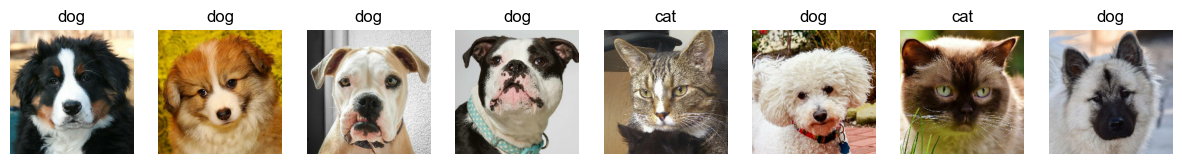

In [55]:
plt.figure(figsize=(15, 10))

for images, labels in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(5, 8, i+1)
        plt.imshow(images[i])
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [20]:
from tensorflow.keras import layers, models, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

def VGG16(nb_classes, input_shape):
    input_tensor = Input(shape=input_shape)

    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(input_tensor)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    x = Flatten()(x)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    output_tensor = Dense(nb_classes, activation='softmax', name='predictions')(x)

    model = Model(input_tensor, output_tensor)
    return model

model=VGG16(1000, (img_width, img_height, 3))
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [43]:
from tqdm import tqdm

epochs = 10
lr = 1e-4

history_train_loss = []
history_train_accuracy = []
history_val_loss = []
history_val_accuracy = []

for epoch in range(epochs):
    train_total = len(train_ds)
    val_total = len(val_ds)

    with tqdm(total=train_total, desc=f'Epoch {epoch+1}/{epochs}', mininterval=1, ncols=100) as phar:
        # total=train_total:进度条的总长度
        # desc:设置进度条前面的描述文本
        # mininterval:设置进度条更新的最小时间间隔
        # ncols:进度条的宽度(字符数)
        lr = lr*0.92 # 学习率衰减
        model.optimizer.learning_rate.assign(lr)

        for image, label in train_ds:
            history = model.train_on_batch(image, label)
            train_loss = history[0]
            train_accuracy = history[1]

            phar.set_postfix({'loss': '%.4f' % train_loss,
                             'accuracy': '%.4f' % train_accuracy,
                             'lr': model.optimizer.learning_rate.numpy()})
            phar.update(1)
        history_train_loss.append(train_loss)
        history_train_accuracy.append(train_accuracy)
    print('开始验证!')

    with tqdm(total=val_total, desc=f'Epoch {epoch+1}/{epochs}',mininterval=0.3, ncols=100) as phar:
        for image, label in val_ds:
            history = model.test_on_batch(image, label)
            val_loss = history[0]
            val_accuracy = history[1]
            phar.set_postfix({'loss': '%.4f' % val_loss,
                            'accuracy': '%.4f' % val_accuracy})
            phar.update(1)
        history_val_loss.append(val_loss)
        history_val_accuracy.append(val_accuracy)
    print('结束验证!')
    print('验证loss为: %.4f' % val_loss)
    print('验证准确率为: %.4f' % val_accuracy)

Epoch 1/10: 100%|████████| 340/340 [17:04<00:00,  3.01s/it, loss=0.7857, accuracy=0.5732, lr=9.2e-5]


开始验证!


Epoch 1/10: 100%|█████████████████████| 85/85 [01:04<00:00,  1.31it/s, loss=0.7317, accuracy=0.6124]


结束验证!
验证loss为: 0.7317
验证准确率为: 0.6124


Epoch 2/10: 100%|███████| 340/340 [16:57<00:00,  2.99s/it, loss=0.5562, accuracy=0.7225, lr=8.46e-5]


开始验证!


Epoch 2/10: 100%|█████████████████████| 85/85 [01:03<00:00,  1.33it/s, loss=0.5190, accuracy=0.7438]


结束验证!
验证loss为: 0.5190
验证准确率为: 0.7438


Epoch 3/10: 100%|███████| 340/340 [17:27<00:00,  3.08s/it, loss=0.4047, accuracy=0.8045, lr=7.79e-5]


开始验证!


Epoch 3/10: 100%|█████████████████████| 85/85 [01:11<00:00,  1.19it/s, loss=0.3839, accuracy=0.8156]


结束验证!
验证loss为: 0.3839
验证准确率为: 0.8156


Epoch 4/10: 100%|███████| 340/340 [16:58<00:00,  2.99s/it, loss=0.3174, accuracy=0.8485, lr=7.16e-5]


开始验证!


Epoch 4/10: 100%|█████████████████████| 85/85 [01:03<00:00,  1.35it/s, loss=0.3048, accuracy=0.8549]


结束验证!
验证loss为: 0.3048
验证准确率为: 0.8549


Epoch 5/10: 100%|███████| 340/340 [16:41<00:00,  2.95s/it, loss=0.2624, accuracy=0.8764, lr=6.59e-5]


开始验证!


Epoch 5/10: 100%|█████████████████████| 85/85 [01:03<00:00,  1.34it/s, loss=0.2539, accuracy=0.8806]


结束验证!
验证loss为: 0.2539
验证准确率为: 0.8806


Epoch 6/10: 100%|███████| 340/340 [16:40<00:00,  2.94s/it, loss=0.2244, accuracy=0.8953, lr=6.06e-5]


开始验证!


Epoch 6/10: 100%|█████████████████████| 85/85 [01:03<00:00,  1.34it/s, loss=0.2198, accuracy=0.8976]


结束验证!
验证loss为: 0.2198
验证准确率为: 0.8976


Epoch 7/10: 100%|███████| 340/340 [16:18<00:00,  2.88s/it, loss=0.1975, accuracy=0.9087, lr=5.58e-5]


开始验证!


Epoch 7/10: 100%|█████████████████████| 85/85 [01:03<00:00,  1.34it/s, loss=0.1930, accuracy=0.9109]


结束验证!
验证loss为: 0.1930
验证准确率为: 0.9109


Epoch 8/10: 100%|███████| 340/340 [15:39<00:00,  2.76s/it, loss=0.1749, accuracy=0.9194, lr=5.13e-5]


开始验证!


Epoch 8/10: 100%|█████████████████████| 85/85 [01:03<00:00,  1.34it/s, loss=0.1723, accuracy=0.9210]


结束验证!
验证loss为: 0.1723
验证准确率为: 0.9210


Epoch 9/10: 100%|███████| 340/340 [15:44<00:00,  2.78s/it, loss=0.1598, accuracy=0.9274, lr=4.72e-5]


开始验证!


Epoch 9/10: 100%|█████████████████████| 85/85 [01:03<00:00,  1.33it/s, loss=0.1568, accuracy=0.9288]


结束验证!
验证loss为: 0.1568
验证准确率为: 0.9288


Epoch 10/10: 100%|██████| 340/340 [15:47<00:00,  2.79s/it, loss=0.1450, accuracy=0.9342, lr=4.34e-5]


开始验证!


Epoch 10/10: 100%|████████████████████| 85/85 [01:03<00:00,  1.34it/s, loss=0.1427, accuracy=0.9354]

结束验证!
验证loss为: 0.1427
验证准确率为: 0.9354


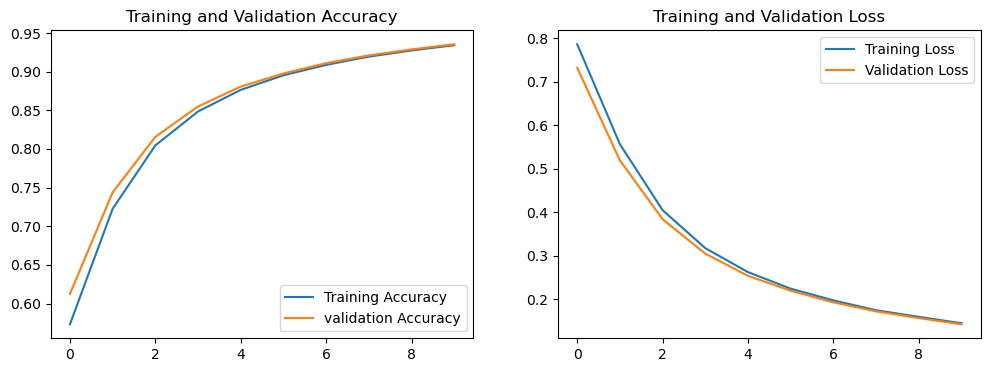

In [51]:
epochs_range = range(epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, history_train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, history_val_accuracy, label='validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history_train_loss, label='Training Loss')
plt.plot(epochs_range, history_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [45]:
model.save('20_model.h5')

new_model = tf.keras.models.load_model('20_model.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


2025-08-24 14:06:58.423234: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


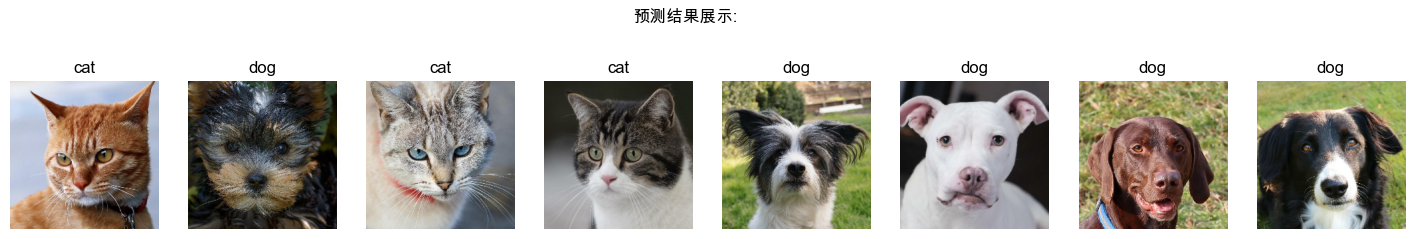

In [53]:
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.figure(figsize=(18, 3))
plt.suptitle('预测结果展示:')

for images, labels in val_ds.take(1):
    for i in range(8):
        ax = plt.subplot(1, 8, i+1)
        plt.imshow(images[i].numpy())
        img_array = tf.expand_dims(images[i], 0)
        predictions = new_model.predict(img_array)
        plt.title(class_names[np.argmax(predictions)])
        plt.axis('off')